# A K process model for stellar abundances

## Authors:
- **Emily J. Griffith** (Colorado)
- **David W. Hogg** (NYU) (MPIA) (Flatiron)

## Notes:
- This code was used in the Griffith et al. (2023b):
- The notebook reads in the necessary files from www.emilyjgriffith.com
- In cell (9) the user can set `q_CC_Fe` and `dq_CC_Fe_dZ`


# Load Packages

In [1]:
!pip install jaxopt

In [2]:
!pip install wget

In [3]:
!pip install corner

In [4]:
import numpy as np
import jax.numpy as jnp
from jax.scipy.special import logsumexp
import jaxopt
import wget
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import os.path
from tqdm import tqdm
from jax import vmap, grad, jit
from functools import partial
import time
import pickle
import corner

In [5]:
from jax.config import config
config.update("jax_enable_x64", True)

In [6]:
# Revise default plotting style
style_revisions = {
            'axes.linewidth': 1.5,
            'xtick.top' : True,
            'ytick.right' : True,
            'xtick.direction' : 'in',
            'ytick.direction' : 'in',
            'xtick.major.size' : 11,
            'ytick.major.size' : 11,
            'xtick.minor.size' : 5.5,
            'ytick.minor.size' : 5.5,
            'font.size' : 16,
            'figure.figsize' : [6, 6],
            'lines.linewidth' : 2.5,
        }
plt.rcParams.update(style_revisions)

# Set Constants and Download Files

In [7]:
rng = np.random.default_rng(42) # for all important random numbers
rng2 = np.random.default_rng(17) # for random numbers used just in plotting

In [8]:
# Set constants
ln10 = np.log(10.)

In [9]:
# Set hyper-parameters
K = 2              # number of processes
processes_all = np.array(['CC', 'Ia', 'AGB', 'fourth']) # process names
processes = processes_all[:K]
Lambda_a = 1.e6    # regularization strength on fixed parameters
q_CC_Fe = 0.4     # q_CC,Fe at Z=0
dq_CC_Fe_dZ = 0.0  # slope wrt Z
Lambda_c = 1.e3    # regularization strength on everything else in q
Lambda_d = 1.e3    # regularization strength on the A values for processes 3+
sqrt_Lambda_A = jnp.ones(K) * jnp.sqrt(Lambda_d) # see way above
sqrt_Lambda_A = jnp.where(processes == "CC", 0., sqrt_Lambda_A)
sqrt_Lambda_A = jnp.where(processes == "Ia", 0., sqrt_Lambda_A)
def get_A_regularization():
    return sqrt_Lambda_A

In [10]:
# Download files from Emily's website
url = 'https://www.emilyjgriffith.com/s/'
if(os.path.isfile('lnqs.npy')==False): wget.download(url+'lnqs.npy') # W22 q vectors
if(os.path.isfile('lnAs.npy')==False): wget.download(url+'lnAs.npy') # W22 A vectors
if(os.path.isfile('alldata_train.npy')==False): wget.download(url+'alldata_train.npy') # APOGEE stellar abundances
if(os.path.isfile('allivars_train.npy')==False): wget.download(url+'allivars_train.npy') # APOGEE stellar abundance inverse variances

In [11]:
# Load numpy files
# N - number of stars = 48659
# M - number of elements = 15

elements  = np.array(['Mg','O','Si','S','Ca','CN','Na','Al','K','Cr','Fe','Ni','Mn','Co','Ce'])
M = len(elements)

# lnqs: shape(2, 12, 16), 0 is qcc, 1 is qIa, replaced negative values with 0.05
w22_lnqs = np.load('lnqs.npy')
w22_lnqs = w22_lnqs[:,:,[0,1,2,3,4,5,6,7,8,9,10,11,13,14,15]] # remove V
w22_lnAs = np.load('lnAs.npy')
w22_metallicity_labels = np.array(['-0.7', '-0.6', '-0.5', '-0.4', '-0.3',
                                   '-0.2', '-0.1', '0.0', '0.1', '0.2', '0.3',
                                   '0.4', ])
w22_metallicities = np.array([float(m) for m in w22_metallicity_labels])
a, b, c = w22_lnqs.shape
assert b == len(w22_metallicities)
assert c == M

# artificially raise the zeros above zero
w22_lnqs = np.clip(w22_lnqs, -7., None)

# alldata: shape(48659, 15), bad data = 0
alldata = np.load('alldata_train.npy')
N, b = alldata.shape
assert b == len(elements)

# allivars: shape(48659,15), bad data = 0
allivars_orig = np.load('allivars_train.npy')
assert allivars_orig.shape == alldata.shape

In [12]:
# Set up knots and xs for q values
knot_xs = np.array([[-0.8, -0.5, -0.4, -0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.6],
                    [-0.8, -0.5, -0.4, -0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.6]])
kay, Nknot = knot_xs.shape
assert kay == K
ii = 0
assert elements[ii] == "Mg"
xs = alldata[:, ii] # [Mg/H] values

# KPM Functions

In [13]:
def get_lnqs(lnqs, knot_xs, xs):
    """
    ## inputs
    - `lnqs`: shape `(K, Nknot, M)` natural-logarithmic processes
    - `knot_xs`: shape `(Nknot, )` metallicity bin centers
    - `xs`: shape `(N, )` abundance data (used to interpolate the `lnqs`)

    ## outputs
    - shape `(K, N)` natural-logarithmic processes for all stars

    ## comments
    - linear interpolation on vmap
    """
    return jnp.concatenate([vmap(jnp.interp, in_axes=(None, None, 1),
                                 out_axes=(1))(xs, knot_xs[k], lnqs[k])[None, :, :]
                            for k in range(K)], axis=0)

In [14]:
def all_stars_K_process_model(lnAs, lnqs, knot_xs, xs):
    """
    ## inputs
    - `lnAs`: shape `(K, N)` natural-logarithmic amplitudes
    - `lnqs`: shape `(K, Nknot, M)` natural-logarithmic processes
    - `knot_xs`: shape `(Nknot, )` metallicity bin centers
    - `xs`: shape `(N, )` abundance data (used to interpolate the `lnqs`)

    ## outputs
    shape `(M, )` log_10 abundances

    ## comments
    - Note the `ln10`.
    """
    return logsumexp(lnAs[:, :, None]
                     + get_lnqs(lnqs, knot_xs, xs), axis=0) / ln10

In [15]:
def inflate_ivars(data, ivars, lnAs, lnqs, knot_xs, xs, Q=5):
    """
    ## inputs
    - `data`: shape `(M, )` log_10 abundance measurements
    - `ivars`: shape `(M, )` inverse errors on the data
    - `lnAs`: shape `(K, N)` natural-logarithmic amplitudes
    - `lnqs`: shape `(K, Nknot, M)` natural-logarithmic processes
    - `knot_xs`: shape `(Nknot, )` metallicity bin centers
    - `xs`: shape `(N, )` abundance data (used to interpolate the `lnqs`)
    - Q softening parameter, smaller is more agressive

    ## outputs
    shape `(M, )` new array of ivars

    """
    synth = all_stars_K_process_model(lnAs, lnqs, knot_xs, xs)
    diff = data - synth
    chi = diff * jnp.sqrt(ivars)

    return (ivars * Q**2) / (Q**2 + diff**2 * ivars)

In [16]:
def one_star_K_process_model(lnAs, lnqs):
    """
    ## inputs
    - `lnAs`: shape `(K,)` natural-logarithmic amplitudes
    - `lnqs`: shape `(K, M)` natural-logarithmic processes

    ## outputs
    shape `(M, )` log_10 abundances

    ## comments
    - Note the `ln10`.
    """
    return logsumexp(lnAs[:, None] + lnqs, axis=0) / ln10

def one_star_chi(lnAs, lnqs, data, sqrt_ivars, sqrt_Lambda):
    """
    ## inputs
    - `lnAs`: shape `(K, )` natural-logarithmic amplitudes
    - `lnqs`: shape `(K, M)` natural-logarithmic processes
    - `data`: shape `(M, )` log_10 abundance measurements
    - `sqrt_ivars`: shape `(M, )` inverse errors on the data
    - `sqrt_Lambda`: shape `(K, )` regularization strength on As

    ## outputs
    chi for this one star
    """
    return jnp.concatenate([sqrt_ivars * (data - one_star_K_process_model(lnAs, lnqs)),
                            sqrt_Lambda * jnp.exp(lnAs)])

def one_star_A_step(lnqs, data, sqrt_ivars, sqrt_Lambda, init):
    """
    ## inputs
    - `lnqs`: shape `(K, M)` natural-logarithmic processes
    - `data`: shape `(M, )` log_10 abundance measurements
    - `sqrt_ivars`: shape `(M, )` inverse errors on the data
    - `sqrt_Lambda`: shape `(K, )` regularization
    - `init`: shape `(K,)` initial guess for the A vector

    ## outputs
    shape `(K,)` best-fit natural-logarithmic amplitudes

    ## bugs
    - Doesn't check the output of the optimizer AT ALL.
    - Check out the crazy `maxiter` input!
    """
    solver = jaxopt.GaussNewton(residual_fun=one_star_chi, maxiter=4)
    lnAs_init = init.copy()
    chi2_init = np.sum(one_star_chi(lnAs_init, lnqs, data, sqrt_ivars, sqrt_Lambda) ** 2)
    res = solver.run(lnAs_init, lnqs=lnqs, data=data, sqrt_ivars=sqrt_ivars,
                     sqrt_Lambda=sqrt_Lambda)
    chi2_res = np.sum(one_star_chi(res.params, lnqs, data, sqrt_ivars, sqrt_Lambda) ** 2)
    return res.params, chi2_init - chi2_res

def A_step(lnqs, data, sqrt_ivars, knot_xs, xs, old_lnAs):
    """
    ## inputs
    - `lnqs`: shape `(K, Nknot, M)` natural-logarithmic processes
    - `data`: shape `(N, M)` log_10 abundance measurements
    - `sqrt_ivars`: shape `(N, M)` inverse variances on alldata
    - `knot_xs`: shape `(Nknot, )` metallicity knot locations
    - `xs`: shape `(N, )` metallicities (to use with the knots)
    - `old_lnAs`: previous `lnAs`; used for initialization of the optimizer

    ## outputs
    shape `(K, N)` best-fit natural-logarithmic amplitudes

    ## bugs
    - Ridiculous post-processing of outputs, with MAGIC numbers.
    """
    N, M = data.shape
    K, Nknot, em = lnqs.shape
    assert em == M
    assert sqrt_ivars.shape == (N, M)
    assert knot_xs.shape == (K, Nknot)
    assert old_lnAs.shape == (K, N)
    sqrt_Lambda = get_A_regularization()
    new_lnAs, dc2 = vmap(one_star_A_step, in_axes=(1, 0, 0, None, 1),
                    out_axes=(1, 0))(get_lnqs(lnqs, knot_xs, xs), data,
                                     sqrt_ivars, sqrt_Lambda, old_lnAs)
    new_lnAs = jnp.where(dc2 < 0, old_lnAs, new_lnAs)
    if not jnp.all(jnp.isfinite(new_lnAs)):
        print("A-step(): fixing bad elements:", jnp.sum(jnp.logical_not(jnp.isfinite(new_lnAs))))
        new_lnAs = jnp.where(jnp.isfinite(new_lnAs), new_lnAs, old_lnAs)
    if np.any(new_lnAs > 2.0): # MAGIC HACK
        print("A-step(): fixing large elements:", np.sum(new_lnAs > 2.0), np.max(new_lnAs))
        new_lnAs = jnp.where(new_lnAs > 2.0, 2.0, new_lnAs)
    if np.any(new_lnAs < -9.0): # MAGIC HACK
        print("A-step(): fixing small elements:", np.sum(new_lnAs < -9.0), np.min(new_lnAs))
        new_lnAs = jnp.where(new_lnAs < -9.0, -9.0, new_lnAs)
    return new_lnAs, dc2

In [17]:
def one_element_K_process_model(lnqs, lnAs):
    """
    ## inputs
    - `lnqs`: shape `(K, N)` natural-logarithmic process elements
    - `lnAs`: shape `(K, N)` natural-logarithmic amplitudes

    ## outputs
    shape `(N, )` log_10 abundances

    ## comments
    - Note the `ln10`.
    """
    return logsumexp(lnqs + lnAs, axis=0) / ln10

def q_step_regularization(lnqs):
    """
    Build arrays that are used for the regularization of the q step.

    ## inputs
    - `lnqs`: shape `(K, N)` natural-logarithmic process elements

    ## outputs
    - `Lambdas, q0s` regularization amplitudes and mean values; same shape as `lnqs`.

    ## bugs:
    - Depends on many global variables and choices.
    """
    Lambdas = np.zeros_like(lnqs) + Lambda_c # default value
    q0s = np.zeros_like(lnqs) + 0.1 # default value
    fixed = np.zeros_like(lnqs).astype(bool)

    # First point: Strongly require that q_Mg = 1 for CC
    proc = processes == "CC"
    elem = elements == "Mg"
    Lambdas[proc, :, elem] = Lambda_a
    q0s[    proc, :, elem] = 1.0
    fixed[  proc, :, elem] = True

    # Second point: Require that q_Mg = 0 for ALL except CC
    proc = processes != "CC"
    elem = elements == "Mg"
    Lambdas[proc, :, elem] = Lambda_a
    q0s[    proc, :, elem] = 0.0
    fixed[  proc, :, elem] = True

    # Third point: Require that q_Fe has some particular value / form for CC
    proc = processes == "CC"
    elem = elements == "Fe"
    Lambdas[proc, :, elem] = Lambda_a
    q0s[    proc, :, elem] = q_CC_Fe + dq_CC_Fe_dZ * knot_xs[proc]
    fixed[  proc, :, elem] = True

    # Fourth point: Strongly require that q_Fes sum to 1
    proc = processes == "Ia"
    elem = elements == "Fe"
    Lambdas[proc, :, elem] = Lambda_a
    q0s[    proc, :, elem] = 1.0 - (q_CC_Fe + dq_CC_Fe_dZ * knot_xs[proc])
    fixed[  proc, :, elem] = True

    # Now set the form for any AGB process
    proc = processes == "AGB"
    elem = elements == "Ce"
    Lambdas[proc, :, elem] = Lambda_a
    q0s[    proc, :, elem] = 1.0
    fixed[  proc, :, elem] = True
    elem = elements == "Fe" # this goes to Ia
    Lambdas[proc, :, elem] = Lambda_a
    q0s[    proc, :, elem] = 0.0
    fixed[  proc, :, elem] = True
    elem = elements == "Mn" # this goes to fourth
    Lambdas[proc, :, elem] = Lambda_a
    q0s[    proc, :, elem] = 0.0
    fixed[  proc, :, elem] = True

    # Now set the form for a fourth process
    proc = processes == "fourth"
    elem = elements == "Mn"
    Lambdas[proc, :, elem] = Lambda_a
    q0s[    proc, :, elem] = 1.0
    fixed[  proc, :, elem] = True
    elem = elements == "Fe" # this goes to Ia
    Lambdas[proc, :, elem] = Lambda_a
    q0s[    proc, :, elem] = 0.0
    fixed[  proc, :, elem] = True
    elem = elements == "Ce" # this goes to AGB
    Lambdas[proc, :, elem] = Lambda_a
    q0s[    proc, :, elem] = 0.0
    fixed[  proc, :, elem] = True

    return Lambdas, q0s, fixed

def one_element_chi(lnqs, lnAs, data, sqrt_ivars, knot_xs, xs, sqrt_Lambdas, q0s):
    """
    ## inputs
    - `lnqs`: shape `(K, Nknot)` natural-logarithmic process vectors
    - `lnAs`: shape `(K, N)` natural-logarithmic amplitudes
    - `data`: shape `(N, )` log_10 abundance measurements
    - `sqrt_ivars`: shape `(N, )` inverse variances on the data
    - `knot_xs`: shape `(Nknot, )` metallicity bin "centers"
    - `xs` : shape `(N, )` metallicities to use with `metallicities`
    - `sqrt_Lambdas`: shape `(K, Nbin)` list of regularization amplitudes
    - `q0s`: shape `(K, Nknot)`

    ## outputs
    chi for this one star (weighted residual)
    """
    interp_lnqs = get_lnqs(lnqs[:, :, None], knot_xs, xs)[:, :, 0]
    return jnp.concatenate([sqrt_ivars * (data - one_element_K_process_model(interp_lnqs, lnAs)),
                            jnp.ravel(sqrt_Lambdas * (jnp.exp(lnqs) - q0s))])

def one_element_q_step(lnAs, data, sqrt_ivars, knot_xs, xs, sqrt_Lambdas, q0s,
                       fixed, init):
    """
    ## inputs
    - `lnAs`: shape `(K, N)` natural-logarithmic amplitudes
    - `data`: shape `(N, )` log_10 abundance measurements
    - `sqrt_ivars`: shape `(N, )` inverse errors on the data
    - `knot_xs`: shape `(Nknot, )` metallicity bin centers
    - `xs` : shape `(N, )` metallicities to use with `metallicities`
    - ...

    ## outputs
    shape `(K, Nknot)` best-fit natural-logarithmic process elements

    ## bugs
    - Uses the `fixed` input incredibly stupidly.
    - Doesn't check the output of the optimizer AT ALL.
    - Check out the crazy `maxiter` input!
    """
    solver = jaxopt.GaussNewton(residual_fun=one_element_chi, maxiter=4)
    lnqs_init = init.copy()
    chi2_init = np.sum(one_element_chi(lnqs_init, lnAs, data, sqrt_ivars,
                       knot_xs, xs, sqrt_Lambdas, q0s) ** 2)
    res = solver.run(lnqs_init, lnAs=lnAs, data=data, sqrt_ivars=sqrt_ivars,
                     knot_xs=knot_xs, xs=xs,
                     sqrt_Lambdas=sqrt_Lambdas, q0s=q0s)
    chi2_res = np.sum(one_element_chi(res.params, lnAs, data, sqrt_ivars,
                      knot_xs, xs, sqrt_Lambdas, q0s) ** 2)
    return jnp.where(fixed, lnqs_init, res.params), chi2_init - chi2_res

def q_step(lnAs, data, sqrt_ivars, knot_xs, xs, old_lnqs):
    """
    ## inputs
    - `lnAs`: shape `(K, N)` natural-logarithmic amplitudes
    - `alldata`: shape `(N, M)` log_10 abundance measurements
    - `sqrt_allivars`: shape `(N, M)` inverse errors on alldata
    - `knot_xs`: shape `(Nknot, )` metallicity bin centers
    - `xs` : shape `(N, )` metallicities to use with `metallicities`
    - `old_lnqs`: shape `(K, Nbin, M)` initialization for optimizations

    ## outputs
    shape `(K, Nbin, M)` best-fit natural-logarithmic processes

    ## bugs
    - Ridiculous post-processing of outputs.
    """
    N, M = data.shape
    assert lnAs.shape == (K, N)
    assert sqrt_ivars.shape == (N, M)
    kay, Nknot = knot_xs.shape
    assert kay == K
    assert len(xs) == N
    assert old_lnqs.shape == (K, Nknot, M)
    lnqs1 = np.zeros((K, Nknot, M))
    Lambdas, q0s, fixed = q_step_regularization(old_lnqs)
    new_lnqs, dc2 = vmap(one_element_q_step, in_axes=(None, 1, 1, None, None, 2, 2, 2, 2),
                    out_axes=(2, 0))(lnAs, data, sqrt_ivars, knot_xs, xs,
                                jnp.sqrt(Lambdas), jnp.array(q0s),
                                jnp.array(fixed), old_lnqs)
    new_lnqs = jnp.where(dc2 < 0, old_lnqs, new_lnqs)
    if not np.all(jnp.isfinite(new_lnqs)):
        print("q-step(): fixing bad elements:", np.sum(jnp.logical_not(jnp.isfinite(new_lnqs))))
        new_lnqs = jnp.where(jnp.isfinite(new_lnqs), new_lnqs, old_lnqs)
    if np.any(new_lnqs > 1.0): # MAGIC HACK
        print("q-step(): fixing large elements:", np.sum(new_lnqs > 1.0), np.max(new_lnqs))
        new_lnqs = jnp.where(new_lnqs > 1.0, 1.0, new_lnqs)
    if np.any(new_lnqs < -9.0): # MAGIC HACK
        print("q-step(): fixing small elements:", np.sum(new_lnqs < -9.0), np.min(new_lnqs))
        new_lnqs = jnp.where(new_lnqs < -9.0, -9.0, new_lnqs)
    return new_lnqs, dc2

In [18]:
def objective_q(lnAs, lnqs, data, sqrt_ivars, knot_xs, xs):
    """
    This is NOT the objective, but it stands in for now!!
    """
    Lambdas, q0s, _ = q_step_regularization(lnqs)
    chi = vmap(one_element_chi, in_axes=(2, None, 1, 1, None, None, 2, 2),
               out_axes=(0))(lnqs, lnAs, data, sqrt_ivars, knot_xs, xs,
                             jnp.sqrt(Lambdas), q0s)
    sqrt_Lambda = get_A_regularization()
    return np.sum(chi * chi) + np.sum((sqrt_Lambda[:, None] * jnp.exp(lnAs)) ** 2)

def objective_A(lnAs, lnqs, data, sqrt_ivars, knot_xs, xs):
    """
    This is NOT the objective, but it stands in for now!!
    """
    sqrt_Lambda = get_A_regularization()
    chi = vmap(one_star_chi, in_axes=(1, 1, 0, 0, None),
               out_axes=(0))(lnAs, get_lnqs(lnqs, knot_xs, xs),
                             data, sqrt_ivars, sqrt_Lambda)
    Lambdas, q0s, _ = q_step_regularization(lnqs)
    return np.sum(chi ** 2) + np.sum(Lambdas * (jnp.exp(lnqs) - q0s) ** 2)

def Aq_step(data, sqrt_ivars, knot_xs, xs, ln_noise, old_lnAs, old_lnqs, rng=rng):
    """
    ## Bugs:
    - This contains multiple hacks.
    - Maybe some of the hacks should be pushed back into the A-step and
      the q-step?
    """
    prefix = "Aq-step():"
    old_objective = objective_A(old_lnAs, old_lnqs, data, sqrt_ivars, knot_xs, xs)

    # fix old_lnAs
    old_lnAs = jnp.where(jnp.isnan(old_lnAs), 1., old_lnAs)

    # add noise
    A_noise = ln_noise + np.log(rng.uniform(size=old_lnAs.shape))
    init_lnAs = jnp.logaddexp(old_lnAs, A_noise)
    q_noise = ln_noise + np.log(rng.uniform(size=old_lnqs.shape))
    q_noise[:, :, elements == "Mg"] = -np.inf # HACK
    q_noise[:, :, elements == "Fe"] = -np.inf # HACK
    init_lnqs = jnp.logaddexp(old_lnqs, q_noise)

    # run q step
    objective1 = objective_q(init_lnAs, old_lnqs, data, sqrt_ivars, knot_xs, xs)
    new_lnqs, _ = q_step(init_lnAs, data, sqrt_ivars, knot_xs, xs, old_lnqs)
    objective2 = objective_q(init_lnAs, new_lnqs, data, sqrt_ivars, knot_xs, xs)
    if objective2 > objective1:
        print(prefix, "q-step WARNING: objective function got worse:", objective1, objective2)
        new_lnqs = old_lnqs.copy()
        objective2 = objective1

    # run A step
    objective3 = objective_A(init_lnAs, new_lnqs, data, sqrt_ivars, knot_xs, xs)
    new_lnAs, _ = A_step(new_lnqs, data, sqrt_ivars, knot_xs, xs, init_lnAs)
    objective4 = objective_A(new_lnAs, new_lnqs, data, sqrt_ivars, knot_xs, xs)
    if objective4 > objective3:
        print(prefix, "A-step WARNING: objective function got worse:", objective3, objective4)
        new_lnAs = init_lnAs.copy()
        objective4 = objective3

    # check objective
    print(old_objective, objective1, objective2, objective3, objective4)
    if objective4 < old_objective:
        print(prefix, "we took a step!", ln_noise, objective4, old_objective - objective4)
        return new_lnAs, new_lnqs, np.around(ln_noise + 0.1, 1)
    else:
        print(prefix, "we didn't take a step :(", ln_noise, old_objective, old_objective - objective4)
        return old_lnAs.copy(), old_lnqs.copy(), np.around(ln_noise - 1.0, 1)

In [19]:
def initialize_2():
    """
    ## Bugs:
    - DOESN'T WORK for K > 2 ??
    - very brittle
    - relies on global variables
    """
    assert K == 2
    lnqs = np.zeros((K, Nknot, M))
    lnAs = np.zeros((K, N))
    _, q0s, fixed = q_step_regularization(lnqs)
    lnq0s = np.log(np.clip(q0s, 1.e-7, None))
    lnqs = np.zeros_like(lnq0s)
    lnqs = jnp.where(fixed, lnq0s, lnqs)

    allivars = allivars_orig.copy()
    sqrt_allivars = np.sqrt(allivars)

    I = [el in ["Mg","Fe"] for el in elements]
    lnAs, _ = A_step(lnqs[:, :, I], alldata[:, I], sqrt_allivars[:, I],
                     knot_xs, xs, lnAs)
    print("initialize_2():", np.median(lnAs[1:] - lnAs[0], axis=1))

    lnqs, _ = q_step(lnAs, alldata, sqrt_allivars, knot_xs, xs, lnqs)
    lnAs, _ = A_step(lnqs, alldata, sqrt_allivars, knot_xs, xs, lnAs)
    print("initialize_2():", np.median(lnAs[1:] - lnAs[0], axis=1))

    allivars = inflate_ivars(alldata, allivars_orig, lnAs, lnqs, knot_xs, xs, Q=7)

    return lnAs, lnqs, allivars

# Implement K=2 Model

In [20]:
# Create pickle file names and check if files exist/if itterations should run

pik_name1 = 'K'+str(K)+'_N'+str(N)+'_qccFe'+str(q_CC_Fe)+'_dq'+str(dq_CC_Fe_dZ)+'_1.out'
pik_name2 = 'K'+str(K)+'_N'+str(N)+'_qccFe'+str(q_CC_Fe)+'_dq'+str(dq_CC_Fe_dZ)+'_2.out'
pik_name3 = 'K'+str(K)+'_N'+str(N)+'_qccFe'+str(q_CC_Fe)+'_dq'+str(dq_CC_Fe_dZ)+'_3.out'

itter_1 = True
itter_2 = True
itter_3 = True

if(os.path.isfile(pik_name1)==True):
  itter_1 = False
  if(os.path.isfile(pik_name2)==True):
    itter_2 = False
    if(os.path.isfile(pik_name3)==True):
      itter_3 = False

In [21]:
# Do round one of iterations if pickle DNE
if itter_1:
  ln_noise = -4.
  new_lnAs, new_lnqs, allivars = initialize_2()
  sqrt_allivars = np.sqrt(allivars)
  for i in range(16):
      new_lnAs, new_lnqs, ln_noise = Aq_step(alldata, sqrt_allivars,
                                            knot_xs, xs, ln_noise, new_lnAs,
                                            new_lnqs)
      print(i + 1, np.median(new_lnAs[1:] - new_lnAs[0], axis=1))

  data = [new_lnAs, new_lnqs, knot_xs]
  with open(pik_name1, "wb") as f:
    pickle.dump(data, f)

else:
  with open(pik_name1, "rb") as f:
    new_lnAs, new_lnqs, knot_xs = pickle.load(f)

A-step(): fixing small elements: 19 -613.1999495065893
initialize_2(): [-0.40269463]
q-step(): fixing small elements: 11 -16.118095650958317
A-step(): fixing large elements: 3 14089.64421344336
A-step(): fixing small elements: 220 -646897682924540.1
initialize_2(): [-0.40423177]
A-step(): fixing large elements: 1 5684.8733825675035
A-step(): fixing small elements: 86 -241590324615692.66
1914878.2175138178 2117346.2220682036 1989747.5779272423 1989747.577927242 1972017.4509672187
Aq-step(): we didn't take a step :( -4.0 1914878.2175138178 -57139.2334534009
1 [-0.40423177]
A-step(): fixing large elements: 1 826.1885350545678
A-step(): fixing small elements: 125 -4237177124442960.0
1914878.2175138178 1942883.0002507588 1908519.9137937329 1908519.9137937329 1898443.8343774856
Aq-step(): we took a step! -5.0 1898443.8343774856 16434.383136332268
2 [-0.40279558]
A-step(): fixing small elements: 88 -5.1578086733781555e+17
1898443.8343774856 1933340.6901935113 1922958.7154432824 1922958.715443

In [22]:
#Between iterations readjust the error bars
allivars = inflate_ivars(alldata, allivars_orig, new_lnAs, new_lnqs, knot_xs, alldata[:,0])
sqrt_allivars = np.sqrt(allivars)

In [23]:
# Now do one more round of optimization

if itter_2:
  ln_noise = -5.
  for i in range(16):
      new_lnAs, new_lnqs, ln_noise = Aq_step(alldata, sqrt_allivars, knot_xs, xs,
                                            ln_noise, new_lnAs, new_lnqs)
      print(i + 1, np.median(new_lnAs[1:] - new_lnAs[0], axis=1))

  data = [new_lnAs, new_lnqs, knot_xs]
  with open(pik_name2, "wb") as f:
    pickle.dump(data, f)

else:
  with open(pik_name2, "rb") as f:
    new_lnAs, new_lnqs, knot_xs = pickle.load(f)

A-step(): fixing small elements: 60 -1.3976195786117496e+16
1611976.2769071548 1639778.471629738 1628793.8592594115 1628793.8592594115 1615482.9638811017
Aq-step(): we didn't take a step :( -5.0 1611976.2769071548 -3506.6869739468675
1 [-0.40317291]
A-step(): fixing small elements: 69 -10169803706279.945
1611976.2769071548 1615808.7040657327 1614384.6402598443 1614384.6402598443 1609505.7490392078
Aq-step(): we took a step! -6.0 1609505.7490392078 2470.5278679470066
2 [-0.40261319]
A-step(): fixing small elements: 68 -1.1547717322373738e+17
1609505.7490392078 1614106.506420928 1613611.684235804 1613611.6842358042 1610743.2240275652
Aq-step(): we didn't take a step :( -5.9 1609505.7490392078 -1237.4749883573968
3 [-0.40261319]
A-step(): fixing small elements: 70 -4.6092415238058003e+17
1609505.7490392078 1610144.5334026944 1610037.73182418 1610037.73182418 1609044.5696597798
Aq-step(): we took a step! -6.9 1609044.5696597798 461.1793794280384
4 [-0.4025364]
A-step(): fixing small elemen

In [24]:
allivars = inflate_ivars(alldata, allivars_orig, new_lnAs, new_lnqs, knot_xs, alldata[:,0])
sqrt_allivars = np.sqrt(allivars)

In [25]:
# Now do one more round of optimization

if itter_3:
  ln_noise = -5.
  for i in range(16):
      new_lnAs, new_lnqs, ln_noise = Aq_step(alldata, sqrt_allivars, knot_xs, xs,
                                            ln_noise, new_lnAs, new_lnqs)
      print(i + 1, np.median(new_lnAs[1:] - new_lnAs[0], axis=1))

  data = [new_lnAs, new_lnqs, knot_xs]
  with open(pik_name3, "wb") as f:
    pickle.dump(data, f)

else:
  with open(pik_name3, "rb") as f:
    new_lnAs, new_lnqs, knot_xs = pickle.load(f)

A-step(): fixing small elements: 59 -2.9789876776089544e+16
1601514.615988196 1629256.3196804076 1617204.6560018007 1617204.6560018004 1607398.2833818656
Aq-step(): we didn't take a step :( -5.0 1601514.615988196 -5883.667393669486
1 [-0.40185271]
A-step(): fixing small elements: 70 -9.66609863167717e+22
1601514.615988196 1605315.3551115338 1603982.8857277753 1603982.8857277753 1602109.7098801194
Aq-step(): we didn't take a step :( -6.0 1601514.615988196 -595.0938919233158
2 [-0.40185271]
A-step(): fixing small elements: 74 -8931035915410191.0
1601514.615988196 1602044.022351525 1601928.0244849916 1601928.0244849916 1601241.2629524928
Aq-step(): we took a step! -7.0 1601241.2629524928 273.35303570330143
3 [-0.40198379]
A-step(): fixing small elements: 72 -1316823646191794.0
1601241.2629524928 1601887.8476221617 1601834.2305116805 1601834.2305116807 1601404.3218950764
Aq-step(): we didn't take a step :( -6.9 1601241.2629524928 -163.0589425836224
4 [-0.40198379]
A-step(): fixing small el

In [26]:
# reset ivars to original values
allivars = allivars_orig

# Visualize K=2 Model

In [27]:
def plot_qs(lnqs):
    """
    # Bugs:
    - Relies on many global variables.
    - Assumes a rigid structure for the processes?
    """
    MgH = np.linspace(np.min(knot_xs[0]), np.max(knot_xs[0]), 300) # plotting xs
    new_qs = np.exp(get_lnqs(lnqs, knot_xs, MgH)) # interp to plotting xs
    w22_MgH = w22_metallicities
    w22_qs = np.exp(w22_lnqs)

    plt.figure(figsize=(10,10))
    for i in range(15):
        plt.subplot(4,4,i+1)
        new_qcc = new_qs[0,:,i]
        new_qIa = new_qs[1,:,i]
        w22_qcc = w22_qs[0,:,i]
        w22_qIa = w22_qs[1,:,i]

        plt.plot(w22_MgH, w22_qcc, 'b-', lw=4, alpha=0.25, label='qcc W22')
        plt.plot(w22_MgH, w22_qIa, 'r-', lw=4, alpha=0.25, label='qIa W22')

        plt.plot(MgH, new_qcc, 'b-', alpha=0.9, label='qcc new')
        plt.plot(MgH, new_qIa, 'r-', alpha=0.9, label='qIa new')

        if K==4:
          new_qagb = new_qs[2,:,i]
          new_q4 = new_qs[3,:,i]

          plt.plot(MgH, new_qagb, 'm-', alpha=0.9, label='qagb new')
          plt.plot(MgH, new_q4, 'c-', alpha=0.9, label='q4 new')

        plt.xlabel('[Mg/H]')
        plt.xlim(np.min(knot_xs), 0.55) #np.max(knot_xs))
        plt.ylabel('q '+elements[i])
        plt.ylim(-0.15, 1.5)

        if i==0:
            plt.legend(ncol=1, fontsize=10)
        #plt.ylim(-0.1,1.1)
    plt.tight_layout()

In [28]:
def plot_model_abundances(lnAs, lnqs, knot_xs, xs, data, sqrt_ivars, noise=False):
    """
    ## bugs:
    - Relies on lots of global variables.
    """
    MgHmin = -1.2

    synthdata = all_stars_K_process_model(lnAs, lnqs, knot_xs, xs)
    synthnoise = 0.
    noisestr = ""
    if noise:
        synthnoise = rng2.normal(size=synthdata.shape) / sqrt_ivars
        noisestr = " + noise"
    fig, axes = plt.subplots(len(elements) - 1, 3, figsize=(12,3 * (len(elements) - 1)))

    for j in range(len(elements) - 1):
        ax = axes[j, 0]
        ax.hist2d(data[:,0], data[:,j+1] - data[:,0],
                  cmap='magma', bins=100, range=[[MgHmin,0.6],[-0.5,0.2]], norm=LogNorm())
        ax.set_xlabel('[Mg/H]')
        ax.set_ylabel('[{}/Mg]'.format(elements[j+1]))
        ax.set_ylim(-0.5,0.2)
        if j == 0:
            ax.set_title('observed')

        ax = axes[j, 1]
        sata = synthdata + synthnoise
        ax.hist2d(sata[:,0], sata[:,j+1] - sata[:,0],
                  cmap='magma', bins=100, range=[[MgHmin,0.6],[-0.5,0.2]], norm=LogNorm())
        ax.set_xlabel('[Mg/H]')
        ax.set_ylabel('[{}/Mg]'.format(elements[j+1]))
        ax.set_ylim(-0.5,0.2)
        if j == 0:
            ax.set_title('predicted' + noisestr)

        ax = axes[j, 2]
        ax.hist2d(sqrt_ivars[:, 0] * (data[:, 0] - synthdata[:, 0]),
                  sqrt_ivars[:, j+1] * (data[:, j+1] - synthdata[:, j+1]),
                cmap='magma', bins=100, range=[[-10, 10], [-10, 10]], norm=LogNorm())
        ax.set_xlabel('[Mg/H] chi')
        ax.set_ylabel('[{}/H] chi'.format(elements[j+1]))
        if j == 0:
            ax.set_title('dimensionless residual')

    plt.tight_layout()

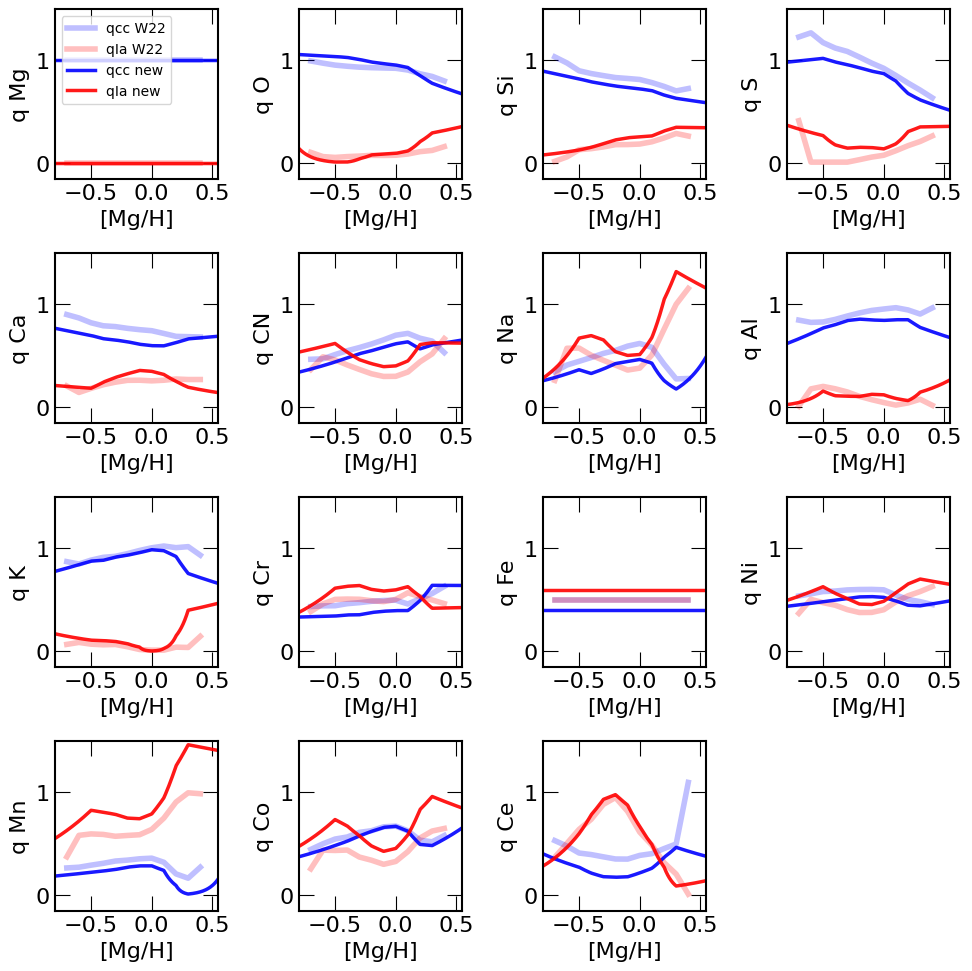

In [29]:
plot_qs(new_lnqs)

<ipython-input-28-16b7df7543ed>:12: RuntimeWarning: divide by zero encountered in true_divide
  synthnoise = rng2.normal(size=synthdata.shape) / sqrt_ivars


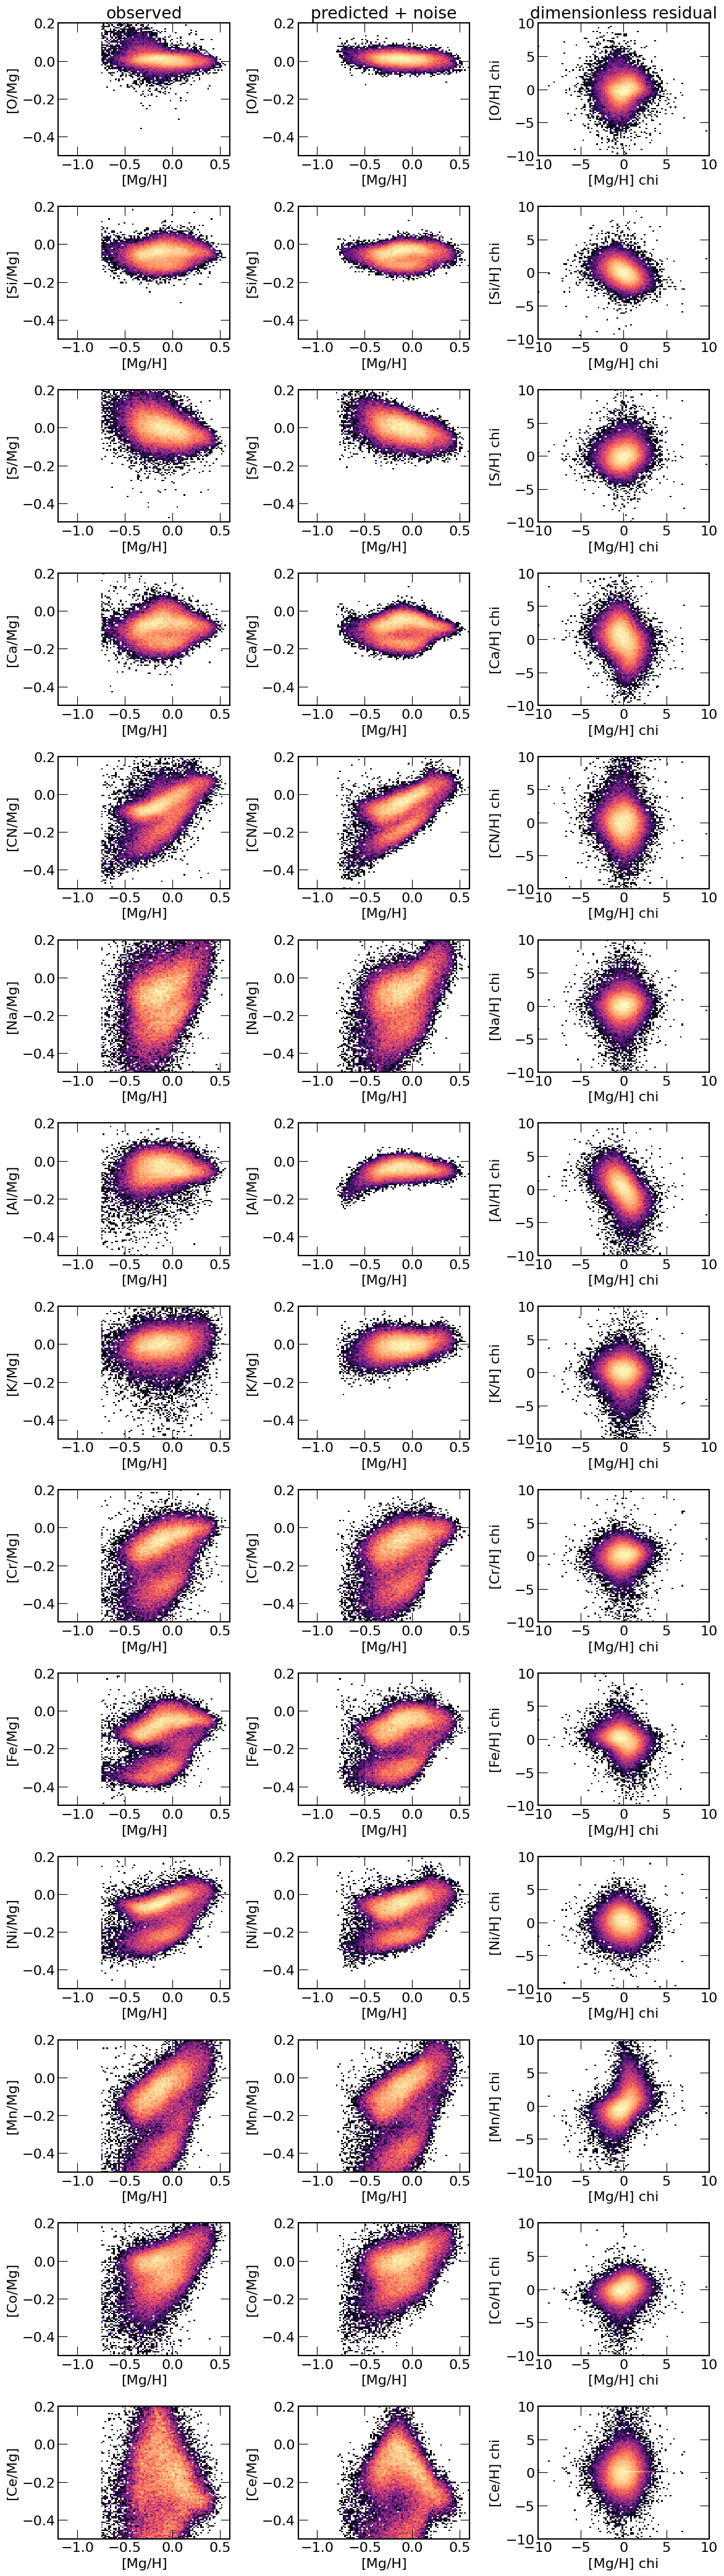

In [30]:
plot_model_abundances(new_lnAs, new_lnqs, knot_xs, xs, alldata,
                      np.sqrt(allivars), noise=True)

# Implement K=4 Model

In [31]:
K = 4
processes = processes_all[:K]
new_lnAs_2, new_lnqs_2 = new_lnAs, new_lnqs

knot_xs = np.array([[-0.8, -0.5, -0.4, -0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.6],
                    [-0.8, -0.5, -0.4, -0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.6],
                    [-0.8, -0.5, -0.4, -0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.6],
                    [-0.8, -0.5, -0.4, -0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.6]])

kay, Nknot = knot_xs.shape
assert kay == K
sqrt_Lambda_A = jnp.ones(K) * jnp.sqrt(Lambda_d) # see way above
sqrt_Lambda_A = jnp.where(processes == "CC", 0., sqrt_Lambda_A)
sqrt_Lambda_A = jnp.where(processes == "Ia", 0., sqrt_Lambda_A)


In [32]:
# Create pickle file names and check if files exist/if itterations should run

pik_name1 = 'K'+str(K)+'_N'+str(N)+'_qccFe'+str(q_CC_Fe)+'_1.out'
pik_name2 = 'K'+str(K)+'_N'+str(N)+'_qccFe'+str(q_CC_Fe)+'_2.out'
pik_name3 = 'K'+str(K)+'_N'+str(N)+'_qccFe'+str(q_CC_Fe)+'_3.out'

itter_1 = True
itter_2 = True
itter_3 = True

if(os.path.isfile(pik_name1)==True):
  itter_1 = False
  if(os.path.isfile(pik_name2)==True):
    itter_2 = False
    if(os.path.isfile(pik_name1)==True):
      itter_3 = False

In [33]:
def initialize_4_from_2(lnAs_2, lnqs_2):
    """
    ## Bugs:
    - this doesn't necesarily initialize close to the two process solution FIX ME
    - DOESN'T WORK for K != 4
    - very brittle
    - relies on global variables
    """
    assert K == 4

    lnqs = jnp.zeros((K, Nknot, M))
    _, q0s, fixed = q_step_regularization(lnqs)
    lnq0s = jnp.log(np.clip(q0s, 1.e-7, None)) # MAGIC
    lnqs = jnp.zeros_like(lnq0s) - 1. # MAGIC
    lnqs = jnp.where(fixed, lnq0s, lnqs)
    lnqs = lnqs.at[0:2].set(lnqs_2)

    lnAs = jnp.zeros((K, N)) - 1. # MAGIC
    lnAs = lnAs.at[0:2].set(lnAs_2)

    I = [el in ["Mg", "Fe", "Ce", "Mn"] for el in elements]
    lnAs, _ = A_step(lnqs[:, :, I], alldata[:, I], sqrt_allivars[:, I],
                     knot_xs, xs, lnAs)
    print("initialize_2():", np.median(lnAs[1:] - lnAs[0], axis=1))

    lnqs, _ = q_step(lnAs, alldata, sqrt_allivars, knot_xs, xs, lnqs)
    lnAs, _ = A_step(lnqs, alldata, sqrt_allivars, knot_xs, xs, lnAs)
    print("initialize_2():", np.median(lnAs[1:] - lnAs[0], axis=1))

    return lnAs, lnqs

In [34]:
# first round of K=4 optimization

if itter_1:
    ln_noise = -5.
    new_lnAs, new_lnqs = initialize_4_from_2(new_lnAs_2, new_lnqs_2)
    for i in range(16):
        new_lnAs, new_lnqs, ln_noise = Aq_step(alldata, sqrt_allivars,
                                               knot_xs, xs, ln_noise, new_lnAs,
                                               new_lnqs)
        print(i + 1, np.median(new_lnAs[1:] - new_lnAs[0], axis=1))
    data = [new_lnAs, new_lnqs, knot_xs]
    with open(pik_name1, "wb") as f:
        pickle.dump(data, f)

else:
    with open(pik_name1, "rb") as f:
        new_lnAs, new_lnqs, knot_xs = pickle.load(f)

A-step(): fixing large elements: 5 18242.90766031748
A-step(): fixing small elements: 17902 -28091.152798587642
initialize_2(): [-0.40802705 -4.93380323 -5.25774163]
q-step(): fixing small elements: 135 -1095.6373454432944
A-step(): fixing large elements: 3 49100.97563070315
A-step(): fixing small elements: 42817 -13304676598.193214
initialize_2(): [-0.40842632 -6.44192848 -5.21544844]
q-step(): fixing small elements: 35 -7710.932751913788
A-step(): fixing large elements: 2 5954.58861653605
A-step(): fixing small elements: 35193 -2074519446.0277386
1641860.0720126939 1700355.8304104882 1668249.0139126896 1668249.0139126894 1555303.0381566314
Aq-step(): we took a step! -5.0 1555303.0381566314 86557.03385606245
1 [-0.40688518 -5.03203858 -4.58774347]
q-step(): fixing small elements: 26 -6524.049398367575
A-step(): fixing small elements: 30941 -8609320635.067047
1555303.0381566314 1632124.5250869007 1620844.3808080363 1620844.380808036 1447885.3350938584
Aq-step(): we took a step! -4.9 14

In [35]:
allivars = inflate_ivars(alldata, allivars_orig, new_lnAs, new_lnqs, knot_xs, alldata[:,0])
sqrt_allivars = np.sqrt(allivars)

In [36]:
# second round of K=4 optimization
if itter_2:
    ln_noise = -6.
    for i in range(16):
        new_lnAs, new_lnqs, ln_noise = Aq_step(alldata, sqrt_allivars,
                                               knot_xs, xs, ln_noise, new_lnAs,
                                               new_lnqs)
        print(i + 1, np.median(new_lnAs[1:] - new_lnAs[0], axis=1))
    data = [new_lnAs, new_lnqs, knot_xs]
    with open(pik_name2, "wb") as f:
        pickle.dump(data, f)

else:
    with open(pik_name2, "rb") as f:
        new_lnAs, new_lnqs, knot_xs = pickle.load(f)

q-step(): fixing small elements: 20 -52540.85807600626
A-step(): fixing small elements: 25901 -6063774501.345521
1455704.8620288994 1467202.4369794524 1466388.7550710288 1466388.7550710286 1454819.144975957
Aq-step(): we took a step! -6.0 1454819.144975957 885.7170529423747
1 [-0.40088781 -4.04173752 -3.72902068]
q-step(): fixing small elements: 20 -39134.411861001085
A-step(): fixing small elements: 25919 -424027435.2152397
1454819.144975957 1468976.2354612064 1468829.514189468 1468829.5141894678 1455543.994654143
Aq-step(): we didn't take a step :( -5.9 1454819.144975957 -724.8496781860013
2 [-0.40088781 -4.04173752 -3.72902068]
q-step(): fixing small elements: 20 -41598.451846381024
A-step(): fixing small elements: 25880 -8662562255.169445
1454819.144975957 1457944.8275480063 1457763.4463197452 1457763.4463197452 1453734.3251595232
Aq-step(): we took a step! -6.9 1453734.3251595232 1084.8198164338246
3 [-0.40160133 -4.04614375 -3.73509067]
q-step(): fixing small elements: 20 -42629.

In [37]:
# reset ivars to original values
allivars = allivars_orig

# Visualize K=4 Model

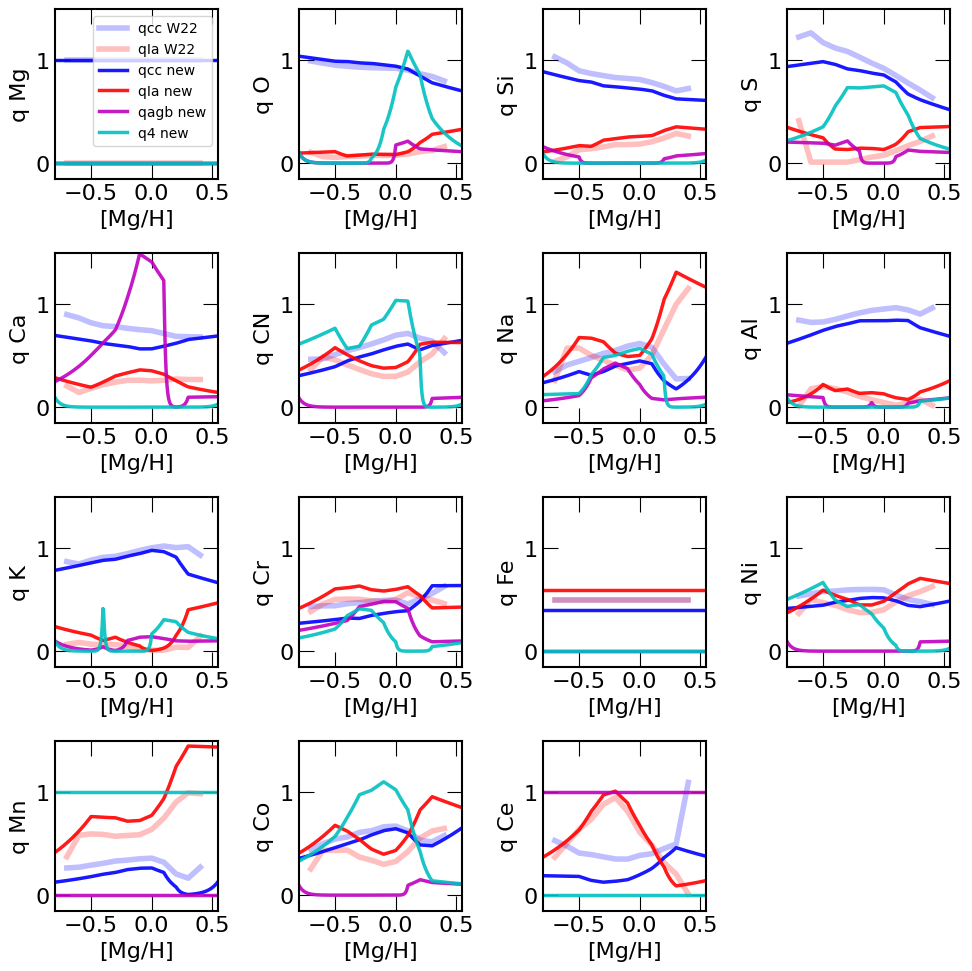

In [38]:
plot_qs(new_lnqs)

<ipython-input-28-16b7df7543ed>:12: RuntimeWarning: divide by zero encountered in true_divide
  synthnoise = rng2.normal(size=synthdata.shape) / sqrt_ivars


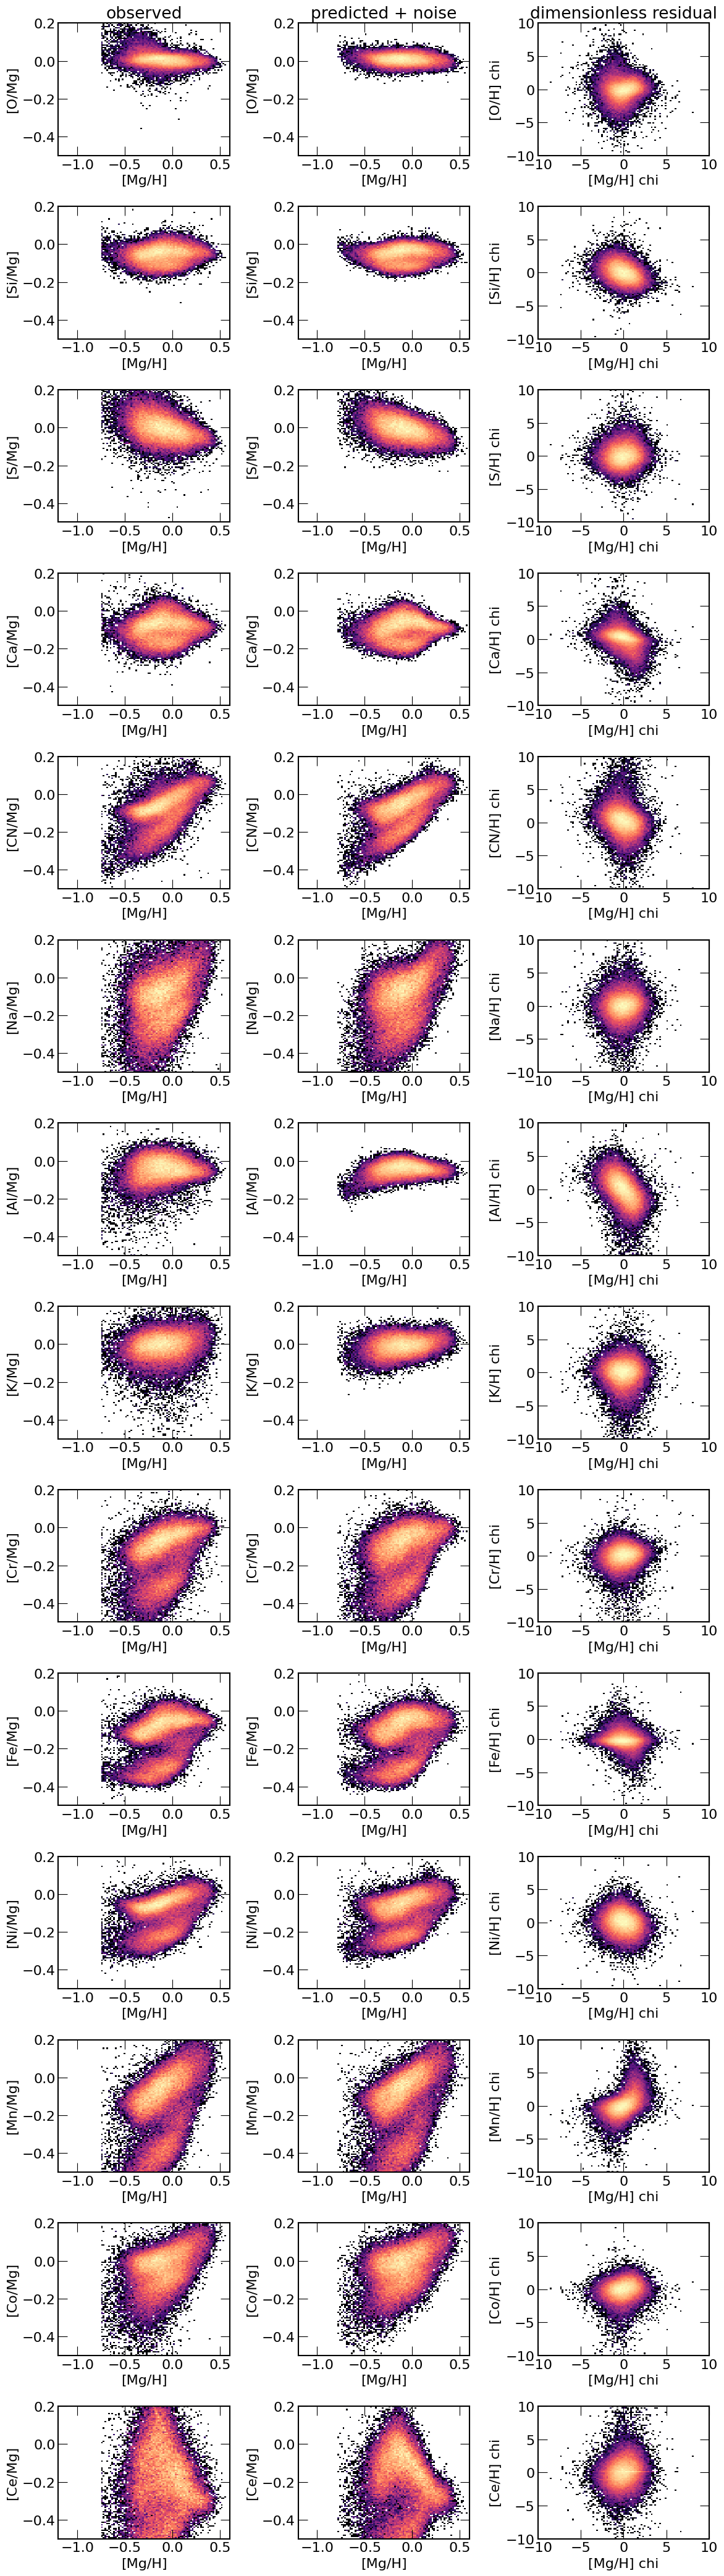

In [39]:
plot_model_abundances(new_lnAs, new_lnqs, knot_xs, xs, alldata, np.sqrt(allivars_orig), noise=True)